<a href="https://colab.research.google.com/github/carlabeh/CarlasRepo/blob/main/WiNoDa_Camera_Trap_Occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leverage the growing wave of ecological data using AI image recognition

## Step 0: Setup & Dataset Download

1. Make a copy of this Notebook (File -> Save Copy in Drive)
2. Start to download the dataset by hovering over the cell below and clicking the "play" icon in the top left of the cell

In [ ]:
# download camera trap images & metadata
!wget -q --no-parent --recursive -R "index.html*" -P data "https://catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/"

### About the Dataset

The dataset we just downloaded is described in:
Barnett, C.L.; Gashchak, S.; Beresford, N.A.; Wood, M.D. (2022). *Wildlife camera trap photographs from the Chornobyl Exclusion Zone, Ukraine (November 2020 - March 2021) following extensive wildfires.* NERC EDS Environmental Information Data Centre. https://doi.org/10.5285/a657ffc3-8f62-458f-bcb7-30e116807174

It is licensed under the terms of the [Open Government Licence](https://eidc.ceh.ac.uk/licences/OGL/plain).

Study area:
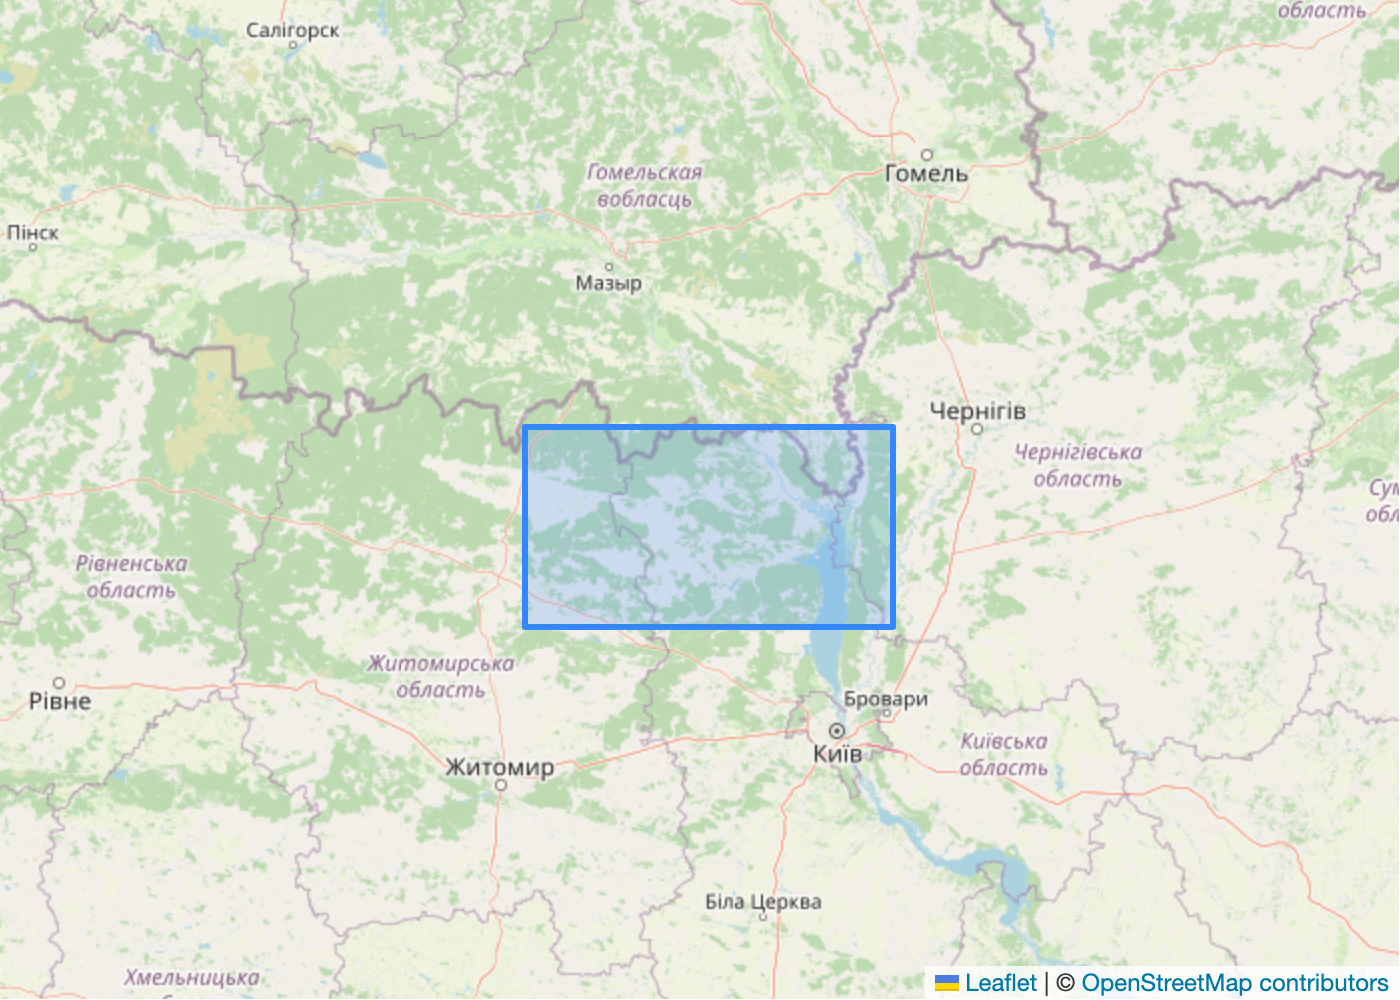

Some example images:
![Example A](https://catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/Setup2_Site_1/Setup2_Site1_1570/Eurasianelk/IMAG0395.JPG)
![Example B](https://catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/Setup2_Site_1/Setup2_Site1_1570/Greywolf/IMAG0342.JPG)
![Example C](https://catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/Setup2_Site_1/Setup2_Site1_1579/Eurasianlynx/IMAG0038.JPG)

## Step 1: Setup our Classifier

In [ ]:
# install SpeciesNet, a machine learning model to classify species in camera trap images
# to learn more about SpeciesNet, see: https://github.com/google/cameratrapai
# for reproducibility, we are installing a specific commit ("version")
!pip install git+https://github.com/google/cameratrapai.git@7ab64e452c119ba0bdc6dd43fffadd9105a48f35

In [ ]:
# define our species of interest
# go to https://www.kaggle.com/models/google/speciesnet?select=taxonomy_release.txt
# to see the full set of available species
species_of_interest = """
ce9a5481-b3f7-4e42-8b8b-382f601fded0;mammalia;lagomorpha;leporidae;lepus;europaeus;european hare
429257d4-3ef2-47fb-b849-66ee6c107346;mammalia;cetartiodactyla;cervidae;alces;alces;moose
ee8d5a89-f82e-4323-80e2-0ffc9487ebaf;mammalia;carnivora;canidae;canis;lupus;grey wolf
eb3829b0-772e-4088-ae90-f11b9fe38284;mammalia;cetartiodactyla;cervidae;cervus;elaphus;red deer
ac0e8ba7-7261-4d17-8645-11ed3d02165a;mammalia;carnivora;canidae;vulpes;vulpes;red fox
317171d7-d306-4e71-9a4a-33e62012076b;mammalia;cetartiodactyla;cervidae;capreolus;capreolus;european roe deer
19fd235e-d808-4e22-bfae-42491045b763;mammalia;perissodactyla;equidae;equus;ferus;przewalski's horse
ea3fb6be-f489-4c8c-9002-bc2d0a22d007;mammalia;carnivora;felidae;lynx;lynx;eurasian lynx
73baf300-5592-4ab5-9da8-7da898477934;mammalia;carnivora;mustelidae;meles;meles;eurasian badger
d372cda5-a8ca-4b7b-97ed-4e4fab9c9b4b;mammalia;cetartiodactyla;suidae;sus;scrofa;wild boar
746d3e98-64af-4897-9cd3-c09b169a8c69;mammalia;carnivora;canidae;nyctereutes;procyonoides;raccoon dog
0f132580-6fc9-4ffa-8e6d-39cdc00c359e;mammalia;carnivora;mustelidae;lutra;lutra;eurasian otter
"""

# save the list into a text file
with open("target_species.txt", "w") as f:
    f.write(species_of_interest)

## Step 2: Classify our Images

In [ ]:
# run the classifier (this may take a while)
!DISABLE_COLAB_CACHE=1 python -m speciesnet.scripts.run_model \
    --noprogress_bars \
    --folders data \
    --predictions_json predictions.json \
    --target_species_txt target_species.txt

In [ ]:
# alternatively, if this takes too long, you can download our precomputed predictions
!curl -L "https://www.dropbox.com/scl/fi/x5l9u0wocw22saxcg8v6f/predictions.json?rlkey=330pydzr8e954xbdnxyt4c8ip&st=kon2ma16&dl=1" > predictions.json

# Step 3: Data Preprocessing

In [ ]:
# next, we are importing some libraries that we will need
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# load site metadata tables
site_descriptions = pd.read_csv("data/catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/CHAR_Nov_2020_Mar_2021_Camera_Trap_Site_Descriptions.csv")
site_details = pd.read_csv("data/catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/CHAR_Nov_2020_Mar_2021_Camera_Trap_Details.csv")

# merge site metadata tables
site_metadata = pd.merge(
    site_descriptions.rename(columns=lambda c: c.replace(" ", "")),
    site_details.rename(columns=lambda c: c.replace(" ", "")),
    on=["Site", "Camera_Location_Identifier"],
)

site_metadata.head()

In [ ]:
# convert degree of burn area to numeric
site_metadata["DegreeOfBurnArea"] = site_metadata["Degree_Of_Burn_Of_Area_Affected_By_Fire_Within_200_Metre_Radius_Of_Camera_Location_Jun_2020"].str.split(" ", n=1, expand=True).iloc[:, 0].map({"None": 0, "Low": 1, "High": 2, "Very": 3})

# index site metadata by camera location identifier
site_metadata["Camera_Location_Identifier"] = site_metadata["Camera_Location_Identifier"].astype(int)
site_metadata = site_metadata.set_index("Camera_Location_Identifier").sort_index()

site_metadata.head()

In [ ]:
# load the image metadata
image_metadata = pd.read_csv("data/catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174/CHAR_Nov_2020_Mar_2021_Camera_Trap_Image_Catalogue.csv")

# parse the date and time
image_metadata["DateTime"] = pd.to_datetime(image_metadata["Date"] + " " + image_metadata["Time"], format="%d/%m/%y %H:%M:%S")

# luckily for us the dataset is fully labeled, to use those labels
# we'll map them to to the taxonomy of the classifier
species_mapping = {
    "Brown hare": "european hare",
    "Eurasian elk": "moose",
    "Grey wolf": "grey wolf",
    "Red deer": "red deer",
    "Red fox": "red fox",
    "Roe deer": "european roe deer",
    "Przewalski's horse": "przewalski's horse",
    "Eurasian lynx": "eurasian lynx",
    "European badger": "eurasian badger",
    "Wild boar": "wild boar",
    "Raccoon dog": "raccoon dog",
    "European otter": "eurasian otter",
}
image_metadata["Species_Common_Name"] = image_metadata["Species_Common_Name"].map(species_mapping)


image_metadata.head()

In [ ]:
# let's parse the classifier predictions into our image metadata

with open("predictions.json", "r") as f:
    predictions = json.load(f)


num_failures = 0
for prediction in predictions["predictions"]:

    # skip failed predictions
    if "failures" in prediction:
        num_failures += 1
        continue

    # extract the filename from the full filepath
    filename = prediction["filepath"].split(os.sep)[-1]

    # extract the site and location from the full filepath
    setup, site, location = prediction["filepath"].split(os.sep)[-3].split("_")
    site = int(site.replace("Site", ""))
    location = int(location)

    # find the image in the metadata
    image_idx = (
        (image_metadata["Site"] == site) &
        (image_metadata["Camera_Location_Identifier"] == location) &
        (image_metadata["Image_Filename"] == filename)
    )

    assert image_idx.sum() == 1, f"Found {image_idx.sum()} images with the same filename in the metadata"

    # add classification logits to the image metadata
    for label, logit in zip(prediction["classifications"]["target_classes"], prediction["classifications"]["target_logits"]):
        common_name = label.split(";")[-1]
        image_metadata.loc[image_idx, common_name] = logit


print(f"Skipped {num_failures} out of {len(predictions['predictions'])} images with failed predictions")

In [ ]:
# print the set of species we've classified
print("Available species:\n" + "\n".join(species_mapping.values()))

# set our target species
# feel free to play around with this!
target_species = "grey wolf"
print(f"Target species: {target_species}")

# set our classifier logit threshold (we will tune this later)
threshold = 0

In [ ]:
def get_observations(image_metadata, threshold):

    # threshold our classification scores of the target species to obtain binary observations
    observations = image_metadata[["DateTime", "Camera_Location_Identifier"]].copy()
    observations["Observed"] = image_metadata[target_species] >= threshold

    # define our aggregation window
    aggregation_window = "W"  # "ME" for monthly, "W" for weekly, "D" for daily

    # sum observations over the specified window
    observations = observations.groupby([pd.Grouper(key="DateTime", freq=aggregation_window), "Camera_Location_Identifier"]).sum(numeric_only=True).reset_index()

    # pivot the table to have datetime as columns and location as rows
    observations = observations.pivot(columns="DateTime", index="Camera_Location_Identifier", values="Observed").sort_index()

    # binarize observations
    observations = (observations >= 1) * 1

    return observations


observations = get_observations(image_metadata, threshold)

# show the first few rows
observations.head()

## Step 4: Fit Occupancy Models

In [ ]:
# first, we are going to install biolith using pip
!pip install biolith==0.0.1

In [ ]:
from biolith.models import occu
from biolith.utils import fit


# only keep site covariates of sites that have observations
site_covariates = site_metadata[site_metadata.index.isin(observations.index)].copy()

# use a single site covariate
# alternatively, you can use any combination of:
# "DegreeOfBurnArea"
# "Camera_Location_Latitude_WGS84_Decimal_Degrees"
# "Camera_Location_Longitude_WGS84_Decimal_Degrees"
# "Ambient_Dose_Rate_At_Camera_Location_Micro_Sievert_Per_Hour_Jun_2020"
site_covariates = site_covariates[["DegreeOfBurnArea"]]

# normalize site covariates
site_covariates = (site_covariates - site_covariates.mean()) / site_covariates.std()

# we will not use observation covariates
observation_covariates = np.zeros((observations.shape[0], observations.shape[1], 0))

# fit model
results = fit(occu, site_covs=site_covariates, obs_covs=observation_covariates, obs=observations, false_positives_unoccupied=True)

# print summary statistics
results.mcmc.print_summary()

# plot the posterior distribution of the occupancy probability
plt.figure(figsize=(10, 6))
plt.hist(results.samples["psi"].mean(axis=0), alpha=0.5)
plt.xlabel("Occupancy probability")
plt.ylabel("Density")
plt.title("Posterior distribution of the occupancy probability")
plt.show()

In [ ]:
# let's define a function to sample images uniformly across the target species logits
def uniform_sample_by_column(df, column, n_samples, n_bins=10, random_state=42):

    # filter to rows that have a value in the column
    valid_df = df[df[column].notna()]

    if valid_df.empty:
        return pd.DataFrame()

    # create bins across the range of values
    bins = np.linspace(valid_df[column].min(), valid_df[column].max(), n_bins+1)
    valid_df['bin'] = pd.cut(valid_df[column], bins=bins)

    # sample equally from each bin
    samples_per_bin = max(1, int(n_samples / n_bins))

    sampled_rows = []
    for _, bin_group in valid_df.groupby('bin'):
        if len(bin_group) > 0:
            n_to_sample = min(samples_per_bin, len(bin_group))
            sampled_rows.append(bin_group.sample(n_to_sample, random_state=random_state))

    # combine and trim to requested sample size
    result = pd.concat(sampled_rows).drop('bin', axis=1)
    if len(result) > n_samples:
        result = result.sample(n_samples, random_state=random_state)

    return result

# sample some rows uniformly across the target species values
n_samples = 20
labeled_data = uniform_sample_by_column(image_metadata, target_species, n_samples)

# visualize the images in the uniform sample
for idx, row in labeled_data.iterrows():

    try:
        filepath = glob.glob(os.path.join(
            "data/catalogue.ceh.ac.uk/datastore/eidchub/a657ffc3-8f62-458f-bcb7-30e116807174",
            f"Setup2_Site_{row['Site']}",
            row["Image_Location_Folder_Name"],
            "*",
            row["Image_Filename"],
        ))[0]

        image = plt.imread(filepath)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"logit({target_species}) = {row[target_species]:.2f}, label = {row['Species_Common_Name']}")
        plt.show()
    except:
        print(f"Failed to visualize image {idx}")

labeled_data


In [ ]:
# get a sorted list of all possible thresholds
possible_thresholds = sorted(image_metadata[target_species].unique())

# initialize variables to keep track of the best threshold and F1 score
best_f1 = float("-inf")
best_thresholds = []

# loop through all possible thresholds
for candidate_threshold in possible_thresholds:

    # see which labeled images would be predicted as positives and negatives given the candidate threshold
    predicted_positives = labeled_data[target_species] >= candidate_threshold
    predicted_negatives = ~predicted_positives

    # see which labeled images are actually positives and negatives
    true_positives = labeled_data["Species_Common_Name"] == target_species
    true_negatives = ~true_positives

    # calculate precision and recall
    precision = (predicted_positives & true_positives).sum() / (predicted_positives.sum() if predicted_positives.sum() > 0 else 1)
    recall = (predicted_positives & true_positives).sum() / (true_positives.sum() if true_positives.sum() > 0 else 1)

    # calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # update the best threshold and F1 score if the current threshold is better
    if f1 == best_f1:
        best_thresholds.append(candidate_threshold)
    elif f1 > best_f1:
        best_f1 = f1
        best_thresholds = [candidate_threshold]


# average over the best thresholds to get a single threshold
best_threshold = np.mean(best_thresholds)

# print the best threshold and F1 score
print(f"Best threshold: {best_threshold:.2f} at F1 score: {best_f1:.2f}")

In [ ]:
# again, convert the image metadata to binary observations,
# but this time using our tuned threshold
observations = get_observations(image_metadata, best_threshold)

In [ ]:
# fit model
results = fit(occu, site_covs=site_covariates, obs_covs=observation_covariates, obs=observations, false_positives_unoccupied=True)

# print summary statistics
results.mcmc.print_summary()

# plot the posterior distribution of the occupancy probability
plt.figure(figsize=(10, 6))
plt.hist(results.samples["psi"].mean(axis=0), bins=50, density=True, alpha=0.5)
plt.xlabel("Occupancy probability")
plt.ylabel("Density")
plt.title("Posterior distribution of the occupancy probability")
plt.show()